Epoch 1/5, Loss: 1.0578
Epoch 2/5, Loss: 0.9690
Epoch 3/5, Loss: 0.9603
Epoch 4/5, Loss: 0.9627
Epoch 5/5, Loss: 0.9563
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       340
           1       0.00      0.00      0.00       165
           2       0.00      0.00      0.00        24
           3       0.64      1.00      0.78       957

    accuracy                           0.64      1486
   macro avg       0.16      0.25      0.20      1486
weighted avg       0.41      0.64      0.50      1486



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


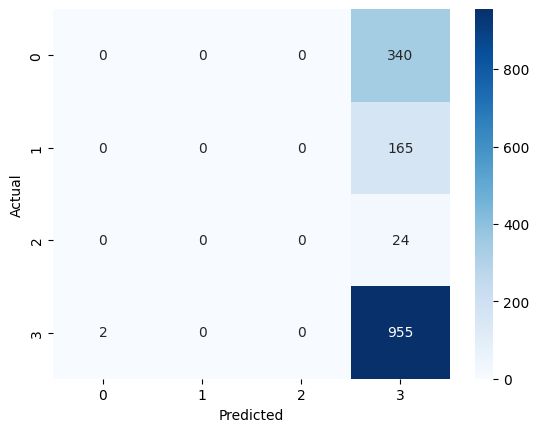

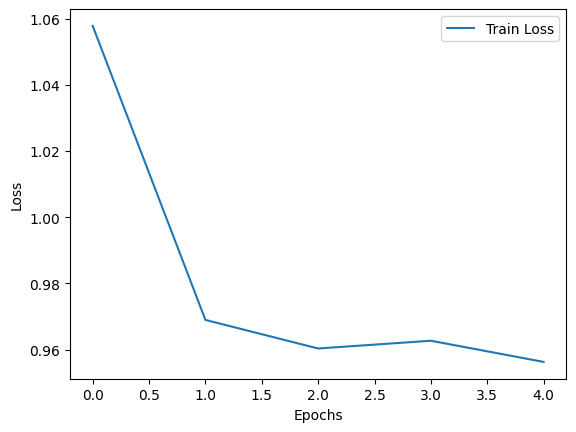

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_data(df):
    encoded_data = tokenizer(df['response'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
    labels = torch.tensor(df['category_int'].tolist())
    return encoded_data['input_ids'], labels

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(30522, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        out = self.fc(self.dropout(gru_out[:, -1, :]))
        return out

# Prepare dataset
def prepare_dataloader(input_ids, labels, batch_size=16):
    train_texts, test_texts, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
    train_dataset = TensorDataset(train_texts, train_labels)
    test_dataset = TensorDataset(test_texts, test_labels)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

# Train function
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=5, device='cuda'):
    model.to(device)
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
    return train_losses

# Evaluation function
def evaluate_model(model, test_dataloader, device='cuda'):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(classification_report(all_labels, all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Hyperparameters
embedding_dim = 128
hidden_dim = 64
output_dim = 4
num_layers = 2
dropout = 0.3
learning_rate = 2e-5
num_epochs = 5

# Load data and prepare dataset
input_ids, labels = tokenize_data(df)
train_dataloader, test_dataloader = prepare_dataloader(input_ids, labels)

# Initialize model, loss, and optimizer
model = GRUClassifier(embedding_dim, hidden_dim, output_dim, num_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Train and evaluate
train_losses = train_model(model, train_dataloader, criterion, optimizer, num_epochs)
evaluate_model(model, test_dataloader)

# Plot training loss
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
